# Time-Weighted Returns
<p style="color:darkblue; "><b>A TurningBull Notebook</b>

The object of this notebook is to demonstrate how to compute simple and time-weighted returns for a time series of price data.

We will start with simple returns, and then show how they can be linked together to yield a compounded time-weighted return.  To accomplish this, we'll use the **yfinance** and **pandas** libraries.  

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [2]:
## Set our parameters
symbol = '^GSPC'                # S&P 500 Index. 
start_date = '2023-01-01'  
end_date = '2024-12-31'         # 2 years of data. 
frequency = '1mo'               # Monthly data.

#### Acquiring the Data
For the sake of simplicity, we're using yfinance, a Yahoo Finance api, to download two years of monthly price data for the S&P 500 Index.

In [3]:
prices = yf.download(symbol, start=start_date, end=end_date, interval=frequency)

print (prices.head())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open        Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC         ^GSPC
Date                                                                        
2023-01-01  4076.600098  4094.209961  3794.330078  3853.290039   80763810000
2023-02-01  3970.149902  4195.439941  3943.080078  4070.070068   80392280000
2023-03-01  4109.310059  4110.750000  3808.860107  3963.340088  113094800000
2023-04-01  4169.479980  4170.060059  4049.350098  4102.200195   70861260000
2023-05-01  4179.830078  4231.100098  4048.280029  4166.790039   88929200000


In [4]:
prices.describe()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
count,24.000000,24.000000,24.000000,24.000000,2.400000e+01
mean,4891.434957,4971.467509,4688.732056,4807.778768,8.298170e+10
std,656.063560,659.775322,637.804842,656.342473,7.836678e+09
min,3970.149902,4094.209961,3794.330078,3853.290039,7.086126e+10
25%,4264.487305,4442.252441,4154.675049,4196.709961,8.033431e+10
50%,4807.739990,4862.194824,4614.304932,4662.015137,8.174252e+10
75%,5475.934937,5555.635132,5148.024780,5340.632446,8.612355e+10
max,6032.379883,6099.970215,5832.299805,6040.109863,1.130948e+11


A quick inspection of the data shows we've downloaded open, high, low, close and volume (OHLCV) fields.  Since we're only interested in the **Close** prices, we'll drop the rest..

In [5]:
spy_close =\
( 
    prices                          # prices dataframe. 
    .droplevel(1, axis=1)           # Simple housekeeping...  drop the ^GSPC ticker from column index.
    .loc[:, ['Close']]              # Select only the 'Close' column.
)
print (spy_close.head())

Price             Close
Date                   
2023-01-01  4076.600098
2023-02-01  3970.149902
2023-03-01  4109.310059
2023-04-01  4169.479980
2023-05-01  4179.830078


#### Simple Returns
A simple return is simply the value at the end of the period, $V_t$, less the value at the beginning of the period, $V_0$, divided by the beginning value, or:

$$
\frac{V_t - V_0}{V_0}   \tag{1}
$$

For example, the 1-month return for the S&P ended Janurary, 2023 is:
$$
\frac{3970.15 - 4076.60}{4076.60} = -2.61\%
$$

Pandas makes this task very easy...

In [6]:
spy_returns = \
(
    spy_close
    .assign(returns1 = lambda df_: df_.Close.pct_change(),      ## The simple way..
            returns2 = lambda df_: df_.Close.rolling(window=2).apply(lambda x: x[1]/x[0] - 1, raw=True))
             ## a little more complex, with a rolling window of 2, apply a lambda function to calculate the returns. 
)
print (spy_returns.head())

Price             Close  returns1  returns2
Date                                       
2023-01-01  4076.600098       NaN       NaN
2023-02-01  3970.149902 -0.026112 -0.026112
2023-03-01  4109.310059  0.035052  0.035052
2023-04-01  4169.479980  0.014642  0.014642
2023-05-01  4179.830078  0.002482  0.002482


The code above shows two different ways to compute single period (simple) returns.  The first method just calls the *pct_change()* function.  The second method applies the return equation from **(1)** as a lambda function.  In terms of efficiency, the first method is likely better.  However, the rolling window method can come in handy for more complex tasks when a built-in function is not available.  We can see below that the two approaches provide equivalent results:

In [7]:
assert (
    spy_returns.returns1.sub(spy_returns.returns2).sum() == 0
)

#### Geometric (Time-Weighted) Returns
Time-weighted returns (TWR) are geometrically-linked simple returns.  They measure the compounded growth of an investment portfolio over time, isolating the impact of investment performance from the effects of cash flows from deposits and withdrawals.  TWRs are a standard measurement to compare portfolio performance over time.  Mathematically, it is computed as:
$$
R_{TWR} = (1 + R_1) \times (1 + R_2) \times ... \times (1 + R_n) - 1  \tag{2}
$$
Where $R_{TWR}$ is the total time-weighted return, and $R_1$, $R_2$, ..., $R_n$ are the individual period returns.  To compute the 2-year TWR for our S&P series, we'll work with the *returns1* field:

In [8]:
spy_2yr_twr = \
(
    spy_returns                             # the returns dataframe.
    .returns1                               # a series of subperiod returns, e.g., monthly simple returns.
    .dropna()                               # drop the first row, which has no prior period return.
    .add(1).cumprod().sub(1)                # calculate the TWR.
    .mul(100)                               # convert to percentage.
    .iloc[-1]                               # take the last value.
)
print (f'S&P 500 2-year total return ended Dec\'24: {spy_2yr_twr:.2f}%')

S&P 500 2-year total return ended Dec'24: 44.28%


Usually, its easier to work with annualized returns for the sake of comparing investments.  An annualized return is just a TWR expressed as an annual growth rate.  It is computed as:
$$
R_{Annual} = (1 + R_{TWR})^{\frac{t}{n}} - 1  \tag{3}
$$
where $R_{TWR}$ is the total return, $t$ is the number of subperiods in a year, and $n$ is the number of subperiods used to compute the total return.  For monthly data, for instance, $t=12$.  Since our TWR is based on 2 years of monthly returns, $n=24$.  Written as a simple lambda function, our annualized returns is:

In [9]:
spy_annualized = ((1 + spy_2yr_twr/100)**(1./2) - 1) * 100
print (f'S&P 500 annualized return: {spy_annualized:.2f}%')

S&P 500 annualized return: 20.12%


Bringing it all together, starting with closing prices, we can compute the annualized return for the S&P 500 ended Dec'24 as:

In [10]:
spy_annualized2 =\
(
    spy_close                               # the prices dataframe.
    .pct_change()                           # calculate the simple returns.
    .dropna()                               # drop the first row, which has no prior period return.
    .add(1).cumprod()                       # calculate the TWR.
    .pow(12. / len(spy_close)).sub(1)       # annualize the TWR.
    .mul(100)                               # convert to percentage.   
    .iloc[-1].values[0]                     # take the last value.
)

assert spy_annualized == spy_annualized2

#### Visualizing the Return Series
In this section, we'll look a how to visualize the S&P 500's monthly returns with **matplotlib***.  To demonstrate some of the plotting library's capabilities, we'll create a figure with two plots.  The top plot will simply plot the cumulative total return through time.  For the second plot, we'll plot the monthly simple returns with a histogram to help understand the distribution of returns.  I've added a few extra bells and whistles mainly for stylistic purposes.

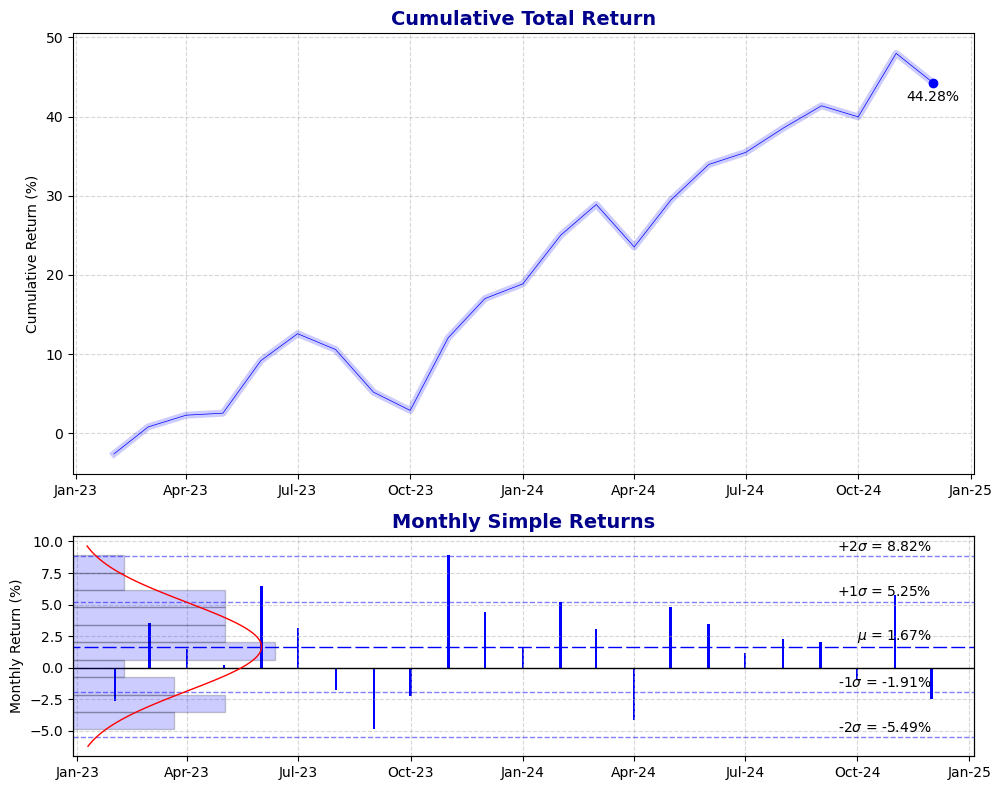

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

date_format = '%b-%y'

# Plot cumulative total return
cumulative_returns = ((1 + spy_returns['returns1']).cumprod() - 1) * 100
ax1.plot(cumulative_returns.index, cumulative_returns, alpha=0.2, linewidth=5, color='blue')
ax1.plot(cumulative_returns.index, cumulative_returns, label='Cumulative Return', linewidth=0.5, color='blue')
ax1.plot(spy_returns.index[-1], cumulative_returns.iloc[-1], 'bo')
ax1.set_title('Cumulative Total Return', fontweight='bold', fontsize=14, color='darkblue')
ax1.set_ylabel('Cumulative Return (%)')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(date_format))
ax1.text(spy_returns.index[-1], cumulative_returns.iloc[-1] * 0.98, f'{cumulative_returns.iloc[-1]:.2f}%', va='top', ha='center')

# Plot monthly simple returns
ax2.bar(spy_returns.index, spy_returns['returns1'] * 100, label='Monthly Returns', width=2, color='blue')
ax2.set_title('Monthly Simple Returns', fontweight='bold', fontsize=14, color='darkblue')
ax2.set_ylabel('Monthly Return (%)')
ax2.grid(True, which='both', linestyle='--', alpha=0.5)
ax2.axhline(y=0, color='black', linewidth=1)
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(date_format))
ax2.axhline(y=spy_returns['returns1'].mean() * 100, color='blue', linewidth=1, linestyle=(5, (10,3)))
ax2.text(spy_returns.index[-1], spy_returns['returns1'].mean() * 100 * 1.1, f'$\\mu$ = {spy_returns["returns1"].mean():.2%}', va='bottom', ha='right')
for i in [-2, -1, 1, 2]:
    ax2.axhline(y=spy_returns['returns1'].mean() * 100 + i * spy_returns['returns1'].std() * 100, color='blue', linewidth=1, linestyle='--', alpha=0.5)

    ax2.text(spy_returns.index[-1], spy_returns['returns1'].mean() * 100 * 1.1 + i * spy_returns['returns1'].std() * 100, f'{i:+d}$\\sigma$ = {spy_returns["returns1"].mean() + i * spy_returns["returns1"].std():.2%}', va='bottom', ha='right')

# Plot a histogram of monthly returns
axhist = ax2.twiny()
bars = axhist.hist(spy_returns['returns1'] * 100, bins=10, orientation='horizontal', alpha=0.2, color='blue', edgecolor='black')
axhist.set_xlim(0, bars[1].max() * 2)
axhist.xaxis.set_visible(False)

# overlay a normal distribution line on the histogram
mu, std = norm.fit(spy_returns['returns1'].dropna() * 100)
ymin, ymax = axhist.get_ylim()
y = np.linspace(ymin, ymax, 100)
x = norm.pdf(y, mu, std)
axhist.plot(x / x.sum() * 200, y, 'r-', linewidth=1)

# Show the plots
plt.tight_layout()
plt.show()